In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import animation
from itertools import combinations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import animation
from itertools import combinations

class Particle:

    def __init__(self, x, y, vx, vy, radius=0.01, styles=None):
        # x, y: position of the particle
        # vx, vy: velocity of the particle
        # radius: radius of particle (circle)
        # style: color of the particle

        self.r = np.array((x, y))
        self.v = np.array((vx, vy))
        self.radius = radius

        self.styles = styles
        if not self.styles:
            # Default value of the style
            self.styles = {'edgecolor': 'b', 'fill': False}

    @property
    def x(self):
        return self.r[0]
    @x.setter
    def x(self, value):
        self.r[0] = value
    @property
    def y(self):
        return self.r[1]
    @y.setter
    def y(self, value):
        self.r[1] = value
    @property
    def vx(self):
        return self.v[0]
    @vx.setter
    def vx(self, value):
        self.v[0] = value
    @property
    def vy(self):
        return self.v[1]
    @vy.setter
    def vy(self, value):
        self.v[1] = value

    def overlaps(self, other): # collision detection
        # Does the particle collide with the other particle(circle)?
        # if collide, return True
        
        collision_distance = self.radius + other.radius
        
        
        if abs(self.x - other.x) > collision_distance:
            return False
        else:
            if abs(self.y - other.y) > collision_distance:
                return False
            else:
                return True
            #return np.hypot(*(self.r - other.r)) <= collision_distance
        # np.hypot(x1, x2[, out]): sqrt(x1**2 + x2**2)
        # np.hypot(*(self.v - other.v)): distance between the center

    def draw(self, ax):
        # add this particle's circle patch to the Matplotlib Axes ax

        circle = Circle(xy=self.r, radius=self.radius, **self.styles)
        ax.add_patch(circle)
        return circle

    def advance(self, dt):
        # bounce off the walls

        self.r += self.v * dt # the position of the particle after dt

        # Make the Particles bounce off the walls
        if self.x - self.radius < 0: # hit the boundary of the box (left, right)
            self.x = self.radius
            self.vx = -self.vx
            
        if self.x + self.radius > 2:
            self.x = 2 - self.radius
            self.vx = -self.vx
            
        if self.y - self.radius < 0: # hit the boundary of the box (top, bottom)
            self.y = self.radius
            self.vy = -self.vy
            
        if self.y + self.radius > 2:
            self.y = 2 - self.radius
            self.vy = -self.vy

In [3]:
class Simulation:
    # dynamic simulation

    def __init__(self, n, radius=0.01, styles=None):
        # initialize the simulation with number of n particles

        self.init_particles(n, radius, styles)

    def init_particles(self, n, radius, styles=None):

        try:
            iterator = iter(radius)
            assert n == len(radius)
        except TypeError:
            # r is not iterable: turn it into a generator that returns the same value n times
            
            def r_gen(n, radius):
                for i in range(n):
                    yield radius
            radius = r_gen(n, radius)

        self.n = n
        self.particles = []
        for i, rad in enumerate(radius):
            # find a random initial position for this particle.
            
            while True:
                x, y = rad + (2 - 2 * rad) * np.random.random(2)
                # vr = 0.1 * np.random.random() + 0.05
                vr = 0.4 ############################################## change speed
                vphi = 2 * np.pi * np.random.random()
                vx, vy = vr * np.cos(vphi), vr * np.sin(vphi)
                particle = Particle(x, y, vx, vy, rad, styles)
                
                # if overlaps with other particles, make again / if not, add to particles
                for p2 in self.particles:
                    if p2.overlaps(particle):
                        break
                else:
                    self.particles.append(particle)
                    break ##############################################


    def handle_collisions(self):
        # collisions between the particles
        # when collide, the velocity of particle changes

        def change_velocities(p1, p2):
            
            m1, m2 = p1.radius**2, p2.radius**2 # consider mass is proportional to volume
            M = m1 + m2
            r1, r2 = p1.r, p2.r
            d = np.linalg.norm(r1 - r2)**2
            v1, v2 = p1.v, p2.v
            u1 = v1 - 2 * m2 / M * np.dot(v1-v2, r1-r2) / d * (r1 - r2)
            u2 = v2 - 2 * m1 / M * np.dot(v2-v1, r2-r1) / d * (r2 - r1)
            p1.v = u1
            p2.v = u2

        
        # consider every pairs
        ################ toooooooooooo long time
        
        pairs = combinations(range(self.n), 2)
        # pairs = filter(lambda x: abs(x[1] - x[0]) > 2 * self.particles[0].radius, combinations(range(self.n), 2))
        # x[1], x[0] should be x[i]- x[j]
        
        for i,j in pairs:
            if self.particles[i].overlaps(self.particles[j]):
                change_velocities(self.particles[i], self.particles[j])

    def advance_animation(self, dt):

        for i, p in enumerate(self.particles):
            p.advance(dt)
            self.circles[i].center = p.r
        self.handle_collisions()
        return self.circles

    def advance(self, dt):
        
        for i, p in enumerate(self.particles):
            p.advance(dt)
        self.handle_collisions()

    def init(self):

        self.circles = []
        for particle in self.particles:
            self.circles.append(particle.draw(self.ax))
        return self.circles

    def animate(self, i):

        self.advance_animation(0.01)
        return self.circles

    def do_animation(self, save=False):

        fig, self.ax = plt.subplots()
        for s in ['top','bottom','left','right']:
            self.ax.spines[s].set_linewidth(2)
        self.ax.set_aspect('equal', 'box')
        self.ax.set_xlim(0, 2)
        self.ax.set_ylim(0, 2)
        self.ax.xaxis.set_ticks([])
        self.ax.yaxis.set_ticks([])
        anim = animation.FuncAnimation(fig, self.animate, init_func=self.init,
                               frames=800, interval=2, blit=True)
        if save:
            Writer = animation.writers['ffmpeg']
            writer = Writer(fps=100, bitrate=1800)
            anim.save('collision.mp4', writer=writer)
        else:
            plt.show()

In [4]:
import datetime

0:01:18.993038


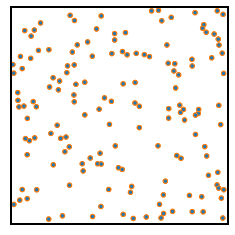

In [5]:
start = datetime.datetime.now()

if __name__ == '__main__':
    nparticles = 150
    # radii = np.random.random(nparticles)*0.03+0.02
    radii = np.array([0.02] * nparticles)
    styles = {'edgecolor': 'C1', 'linewidth': 1, 'fill': 'C1'}
    sim = Simulation(nparticles, radii, styles)
    sim.do_animation(save=True)
    
end = datetime.datetime.now()
print(end - start)

In [29]:
for pair in combinations([1,2,3,4],2):
    print(pair)

(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)
